In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff55ee; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import tensorflow_hub as th,tensorflow as tf
import h5py,imageio,os,torch,pylab as pl
from keras.preprocessing import image as kimage
from tqdm import tqdm
from PIL import ImageFile,Image
ImageFile.LOAD_TRUNCATED_IMAGES=True
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
from IPython.core.magic import register_line_magic

In [4]:
def path_to_tensor(img_path,fpath,img_size):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(img_size,img_size))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath,img_size):
    tensor_list=[path_to_tensor(img_path,fpath,img_size) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

In [5]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,3)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break

In [6]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [7]:
class HorseBreedsData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        img=img.convert('RGB')
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [8]:
dhtml('Data Loaders')

In [9]:
img_size=160
fpath='../input/horse-breeds/'
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
                dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath,img_size),
                dtype='float32')/255
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

100%|██████████| 139/139 [00:01<00:00, 128.28it/s]


,train,valid,test
0,"(113, 160, 160, 3)","(13, 160, 160, 3)","(13, 160, 160, 3)"
1,float32,float32,float32
2,"(113,)","(13,)","(13,)"
3,int8,int8,int8


In [10]:
train_csv='train.csv'
valid_csv='valid_csv'; test_csv='test.csv'
img_path='../input'; img_size2=64
files=[os.path.relpath(os.path.join(dirpath,fn),img_path) \
for (dirpath,dirnames,filenames) in os.walk(img_path) \
for fn in filenames if fn.endswith('.png')]
d={'label':[],'breed':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label=int(fn[:2])-1
    breed=names[label]        
    d['label'].append(label)
    d['breed'].append(breed)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test[:df_test.shape[0]//2].to_csv(test_csv)
df_test[df_test.shape[0]//2:].to_csv(valid_csv)
num_classes=np.unique(df['label'].values).shape[0]
print([num_classes,len(files)]); df_test.head()

[5, 139]


,label,breed,path
file,,,
03_016.png,2,Orlov Trotter,horse-breeds/03_016.png
03_008.png,2,Orlov Trotter,horse-breeds/03_008.png
04_027.png,3,Vladimir Heavy Draft,horse-breeds/04_027.png
02_001.png,1,Appaloosa,horse-breeds/02_001.png
05_024.png,4,Percheron,horse-breeds/05_024.png


In [11]:
batch_size=8; num_workers=4; grayscale=False
trans=transforms\
.Compose([transforms.Resize((img_size2,img_size2)),
          transforms.ToTensor()])
train=HorseBreedsData(csv_path=train_csv,
                      img_dir=img_path,
                      transform=trans)
test=HorseBreedsData(csv_path=test_csv,
                     img_dir=img_path,
                     transform=trans)
valid=HorseBreedsData(csv_path=valid_csv,
                     img_dir=img_path,
                     transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers),
             'valid':tdl(dataset=valid,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers)}

Image dimensions: torch.Size([8, 3, 64, 64])
Label dimensions: torch.Size([8])


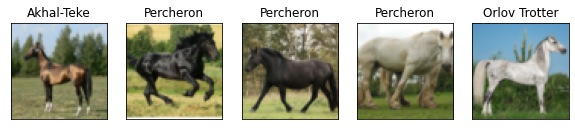

In [12]:
%display_examples valid

In [13]:
dhtml('Classifiers')

In [14]:
fw='weights.best.hdf5'
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [15]:
handle_base="mobilenet_v2_100_160"
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [16]:
kmodel=premodel(img_size,2048,mhandle,5,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=8,
                   epochs=25,callbacks=cb(fw),
                   validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 5,602,606
Trainable params: 5,568,494
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 2.5618 - accuracy: 0.4248
Epoch 00001: val_loss improved from inf to 7.47467, saving model to weights.best.hdf5
15/15 [==============================] - 7s 463ms/step - loss: 2.5618 - accuracy: 0.4248 - val_loss: 7.4747 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 1.9626 - accuracy: 0.6637
Epoch 00002: val_loss improved from 7.47467 to 2.47763, saving model to weights.best.hdf5
15/15 [==============================] - 6s 420ms/step - loss: 1.9626 - accuracy: 0.6637 - val_loss: 2.4776 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 1.9301 - accuracy: 0.7168
Epoch 00003: val_loss did not improve from 2.47763
15/15 [==============================] - 6s 388ms/step - loss: 1.9301 - accuracy: 0.7168 - val_loss: 9.0035 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/25
15/15 [==============================] - ETA: 0s

In [17]:
kmodel.load_weights(fw)
kmodel.evaluate(x_test,y_test)

1/1 [==============================] - 0s 1ms/step - loss: 4.3083 - accuracy: 0.5385


[4.308346271514893, 0.5384615659713745]

In [18]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [20]:
num_classes=5
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [21]:
%train_run 15

Epoch: 001/015 | Batch: 000/015 | Cost: 1.5907
Epoch: 001/015
train acc/loss: 59.48%/1.14 valid acc/loss: 25.00%/1.90
Epoch: 002/015 | Batch: 000/015 | Cost: 1.8031
Epoch: 002/015
train acc/loss: 75.86%/0.66 valid acc/loss: 33.33%/1.53
Epoch: 003/015 | Batch: 000/015 | Cost: 1.1847
Epoch: 003/015
train acc/loss: 86.21%/0.45 valid acc/loss: 41.67%/1.58
Epoch: 004/015 | Batch: 000/015 | Cost: 0.6170
Epoch: 004/015
train acc/loss: 89.66%/0.34 valid acc/loss: 50.00%/1.43
Epoch: 005/015 | Batch: 000/015 | Cost: 0.1506
Epoch: 005/015
train acc/loss: 92.24%/0.33 valid acc/loss: 66.67%/1.53
Epoch: 006/015 | Batch: 000/015 | Cost: 0.7298
Epoch: 006/015
train acc/loss: 95.69%/0.19 valid acc/loss: 41.67%/1.23
Epoch: 007/015 | Batch: 000/015 | Cost: 1.0727
Epoch: 007/015
train acc/loss: 93.10%/0.23 valid acc/loss: 41.67%/1.64
Epoch: 008/015 | Batch: 000/015 | Cost: 0.8757
Epoch: 008/015
train acc/loss: 93.97%/0.17 valid acc/loss: 41.67%/1.58
Epoch: 009/015 | Batch: 000/015 | Cost: 1.4022
Epoch: 00

In [22]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 100.00% || test acc: 72.73%
